# demo


In [1]:
# Demo
import pickle
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle

In [2]:
complementary_mapping1 = {
        "tshirts": ["jeans", "casual shoes", "watches", "belts", "sunglasses", "caps"],
        "shirts": ["trousers", "formal shoes", "belts", "watches", "jeans", "suits"],
        "jeans": ["tshirts", "sneakers", "jackets", "belts", "casual shoes", "watches"],
        "track pants": ["tshirts", "sports shoes", "wristbands", "caps", "hoodies", "socks"],
        "shorts": ["tshirts", "flip flops", "caps", "sunglasses", "wristbands", "sandals"],
        "blazers": ["trousers", "formal shoes", "ties", "watches", "shirts", "cufflinks"],
        "dresses": ["heels", "handbags", "jewelry", "earrings", "perfume and body mist", "bracelets"],
        "skirts": ["tops", "sandals", "handbags", "earrings", "watches", "sunglasses"],
        "suits": ["formal shoes", "ties", "cufflinks", "watches", "belts", "perfume and body mist"],
        "jackets": ["jeans", "boots", "scarves", "casual shoes", "sweaters", "mufflers"],
        "sweaters": ["jeans", "casual shoes", "mufflers", "scarves", "boots", "jackets"],
        "leggings": ["kurtis", "sandals", "dupatta", "heels", "earrings", "handbags"],
        "kurtas": ["leggings", "heels", "earrings", "handbags", "bracelets", "dupatta"],
        "trousers": ["shirts", "formal shoes", "belts", "watches", "suits", "cufflinks"],
        "sweatshirts": ["jeans", "sneakers", "caps", "track pants", "jackets", "wristbands"],
        "flip flops": ["shorts", "tshirts", "caps", "sunglasses", "swimwear", "wristbands"],
        "casual shoes": ["jeans", "tshirts", "belts", "sneakers", "watches", "sunglasses"],
        "formal shoes": ["blazers", "shirts", "watches", "suits", "trousers", "belts"],
        "sports shoes": ["track pants", "tshirts", "wristbands", "caps", "shorts", "sports socks"],
        "heels": ["dresses", "handbags", "earrings", "skirts", "bracelets", "perfume and body mist"],
        "sandals": ["skirts", "leggings", "bracelets", "casual dresses", "earrings", "handbags"],
        "handbags": ["dresses", "heels", "earrings", "bracelets", "skirts", "sunglasses"],
        "watches": ["shirts", "trousers", "suits", "belts", "formal shoes", "sunglasses"],
        "sunglasses": ["casual shoes", "jeans", "caps", "watches", "tshirts", "shorts"],
        "scarves": ["sweaters", "jeans", "boots", "jackets", "mufflers", "casual dresses"],
        "jewelry": ["dresses", "heels", "handbags", "bracelets", "earrings", "perfume and body mist"],
        "ties": ["suits", "formal shoes", "cufflinks", "watches", "shirts", "belts"],
        "mufflers": ["sweaters", "jeans", "casual shoes", "jackets", "scarves", "boots"],
        "caps": ["tshirts", "shorts", "sneakers", "sunglasses", "track pants", "hoodies"],
        "belts": ["jeans", "shirts", "trousers", "suits", "watches", "formal shoes"],
        "earrings": ["dresses", "heels", "handbags", "bracelets", "skirts", "jewelry"],
        "perfume and body mist": ["suits", "formal shoes", "watches", "dresses", "bracelets", "heels"],
        "makeup remover": ["lipstick", "foundation and primer", "mascara", "eyeliner", "blush", "compact powder"],
        "lipstick": ["makeup remover", "foundation and primer", "mascara", "eyeliner", "lip liner", "blush"],
        "foundation and primer": ["lipstick", "makeup remover", "compact powder", "eyeshadow", "blush", "highlighter"]
    }

In [3]:
with open('complementary_mapping.pkl','wb') as file:
    pickle.dump(complementary_mapping1,file)

In [4]:
# Load dataset with metadata
df = pd.read_csv("styles_cleaned.csv",encoding="utf-8")

feature_list=np.array(pickle.load(open('embeddings.pkl','rb')))
filename=pickle.load(open('filename.pkl','rb'))
model=pickle.load(open('model.pkl','rb'))
feature_list.shape

(44441, 2048)

In [5]:
def find_nearest_image(uploaded_image_path, model):
    """Finds the closest matching image in the dataset based on feature similarity."""
    img=image.load_img(uploaded_image_path,target_size=(224,224))
    img_array=image.img_to_array(img)
    exp_img=np.expand_dims(img_array,axis=0)
    prepro_img=preprocess_input(exp_img)
    uploaded_features=model.predict(prepro_img,verbose=0).flatten()
    norm_uploaded=uploaded_features/norm(uploaded_features)
    similarities = cosine_similarity([norm_uploaded], feature_list)
    closest_idx = np.argmax(similarities)
    return filename[closest_idx]

In [6]:
find_nearest_image('sample/1528.jpg',model)

'images\\1528.jpg'

In [7]:
def get_article_type_and_gender(uploaded_image_path, model):
    """Predicts the article type and gender by finding the most similar image in the dataset."""
    nearest_image = find_nearest_image(uploaded_image_path, model)
    nearest_image_id = os.path.splitext(os.path.basename(nearest_image))[0]
    matching_row = df[df['id'] == int(nearest_image_id)]
    if not matching_row.empty:
        return matching_row.iloc[0]['articleType'], matching_row.iloc[0]['gender']
    return None, None

In [8]:
get_article_type_and_gender('sample/1528.jpg',model)

('Jackets', 'Men')

In [9]:
import random
def get_occasion_recommendations(article_type, gender):
    article_type, gender = article_type.strip().lower(), gender.strip().lower()
    df["articleType"] = df["articleType"].str.strip().str.lower()
    df["gender"] = df["gender"].str.strip().str.lower()

    # Check if article type has predefined complementary items
    if article_type in complementary_mapping1:
        related_articles = complementary_mapping1[article_type]
    else:
        # Fallback: Get other articles from the same occasion
        occasion = df[df["articleType"] == article_type]["usage"].values
        if len(occasion) == 0:
            return [("No occasion found", "Check articleType spelling")]
        occasion = occasion[0]  # Assume one occasion per item
        related_articles = df[df["usage"] == occasion]["articleType"].unique().tolist()

    # Filter for recommendations (same gender, related article types)
    recommendations = df[
        (df["articleType"].isin(related_articles)) & 
        (df["gender"] == gender)
    ]

    # Ensure uniqueness: Pick one random product per articleType
    recommendations = recommendations.groupby("articleType").apply(lambda x: x.sample(1, random_state=random.randint(1, 10000)))

    # Select top 5 unique recommendations
    return recommendations[["articleType", "productDisplayName", "id"]].head(5).values.tolist() or [("No complementary items found", "Try another product")]


In [10]:
get_occasion_recommendations('sports shoes', 'Men')[0:5]

C:\Users\Pc\AppData\Local\Temp\ipykernel_13440\656011221.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommendations = recommendations.groupby("articleType").apply(lambda x: x.sample(1, random_state=random.randint(1, 10000)))


[['caps', 'Quiksilver Men Black Beanie Cap', 19433],
 ['shorts', 'Nike Men Solid Grey Shorts', 22584],
 ['track pants', "ADIDAS Men's Light Blue Track Pant", 3482],
 ['tshirts', 'Locomotive Men Printed Blue T-shirt', 21393]]

In [56]:
# Process uploaded image
img_path = 'sample/1607.jpg'
img=image.load_img(img_path,target_size=(224,224))
img_array=image.img_to_array(img)
exp_img=np.expand_dims(img_array,axis=0)
prepro_img=preprocess_input(exp_img)
result=model.predict(prepro_img,verbose=0).flatten()
norm_result=result/norm(result)

Similar Products:


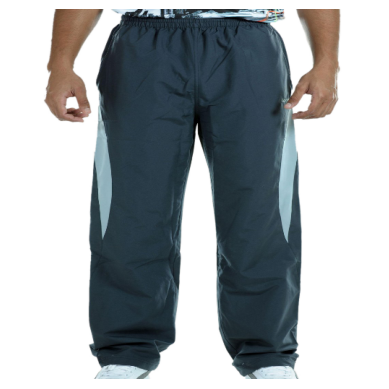

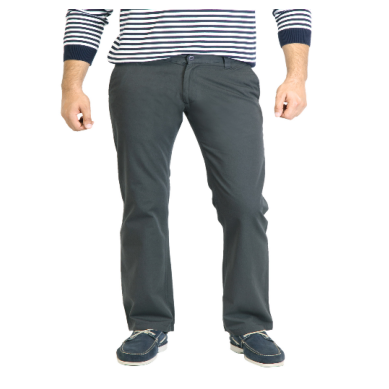

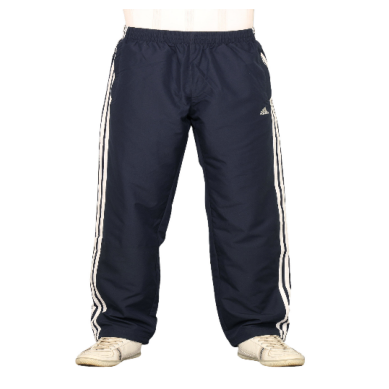

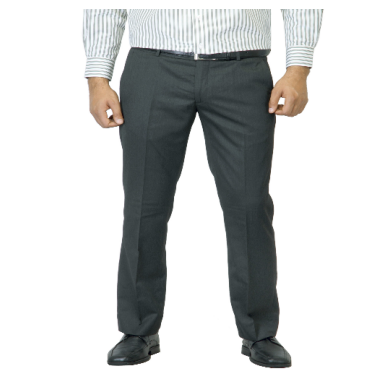

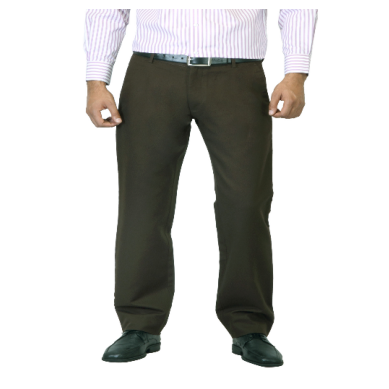

In [57]:
# Find similar images
neighbors=NearestNeighbors(n_neighbors=5,algorithm='brute',metric='euclidean')
neighbors.fit(feature_list)

distances,indices=neighbors.kneighbors([norm_result])
print("Similar Products:")
for file in indices[0]:
    temp_img = cv2.imread(filename[file])
    if temp_img is not None:
        resized_img = cv2.resize(temp_img, (512, 512))
        plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Unable to read image {filename[file]}")

In [58]:
# Get occasion-based recommendations
article_type, gender = get_article_type_and_gender(img_path, model)
if article_type and gender:
    recommendations = get_occasion_recommendations(article_type, gender)
    print(f"\nDetected Article Type: {article_type}, Gender: {gender}")
    print("Recommended Products for this Occasion:")
    for rec in recommendations:
        print(f"- {rec[0]}: {rec[1]}")
else:
    print("\nCould not determine article type or gender.")


Detected Article Type: track pants, Gender: men
Recommended Products for this Occasion:
- caps: Nike Men Cricket Navy Blue Cap
- socks: Arrow Men Pack Of 5 Basic Plating Socks
- sports shoes: ADIDAS Men Blue Response Sports Shoes
- tshirts: Facit Men Smart Maroon Tshirt


C:\Users\Pc\AppData\Local\Temp\ipykernel_13440\656011221.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommendations = recommendations.groupby("articleType").apply(lambda x: x.sample(1, random_state=random.randint(1, 10000)))


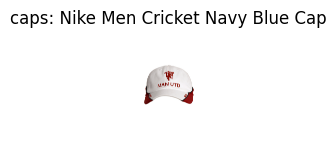

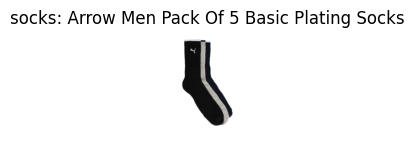

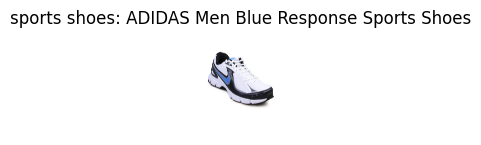

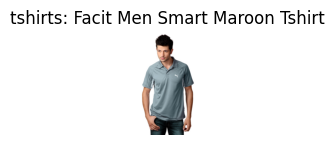

In [64]:
for rec in recommendations:
    # Ensure rec is a tuple or list with at least two elements
    if isinstance(rec, (list, tuple)) and len(rec) >= 2:
        article_type, product_name = rec[:2]  # Extract only the first two values
    else:
         print(f"Skipping invalid recommendation format: {rec}")
         continue
        
        # Find the matching image filename from the dataset
    matching_row = df[df['articleType'] == article_type]
        
    if not matching_row.empty:
        image_id = str(matching_row.iloc[0]['id']) + ".jpg"  # Construct image filename
        image_path = os.path.join("images", image_id)  # Update path if needed

        temp_img = cv2.imread(image_path)
        if temp_img is not None:
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
                
            plt.figure(figsize=(1, 2))
            plt.imshow(temp_img)
            plt.axis('off')
            plt.title(f"{article_type}: {product_name}")
            plt.show()
        else:
            print(f"Error: Image not found for {product_name}")
    else:
        print(f"Image not found for {product_name}")